In [1]:
import time
import numpy as np
import pandas as pd
import json
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import rcParams

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [6]:
dbname = 'tutor_db'
username = 'codonnell'
pswd = '7883511'
engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM tutor_main
LEFT JOIN zip_incomes ON tutor_main.zip_code = zip_incomes.zip_code
"""
tutor_data = pd.read_sql_query(sql_query,con)
tutor_data.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,wednesday_hours,thursday_hours,friday_hours,saturday_hours,mean_hours,index,zip_code,average_age,household_income,pop
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,0.375000,0.375000,0.583333,0.583333,0.500000,NaN,NaN,NaN,NaN,NaN
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,0.583333,0.583333,0.500000,0.333333,0.517857,NaN,NaN,NaN,NaN,NaN
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,0.541667,0.250000,0.416667,0.375000,0.357143,NaN,NaN,NaN,NaN,NaN
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,0.125000,0.125000,0.083333,0.000000,0.089286,NaN,NaN,NaN,NaN,NaN


In [10]:
with_incomes = tutor_data[~tutor_data['household_income'].isnull()]

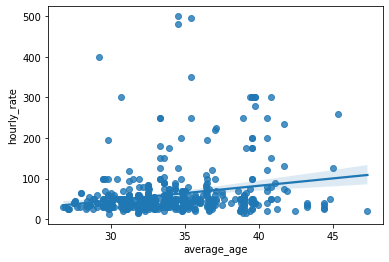

In [14]:
sb.regplot(with_incomes['average_age'],with_incomes['hourly_rate'])

In [23]:
sql_query = """
SELECT zip_code, SUM(num_tutors) AS tot_tutors
FROM tutor_nums
GROUP BY zip_code

"""
tutor_datanum = pd.read_sql_query(sql_query,con)
tutor_datanum.head()

,zip_code,tot_tutors
0,10456,3731.0
1,33467,300.0
2,60625,813.0
3,91706,730.0
4,91710,359.0


In [21]:
sql_query = """
WITH a AS (
SELECT zip_code, COUNT(num_tutors) AS tot_tutors
FROM tutor_nums
GROUP BY zip_code
)

SELECT * FROM tutor_main
LEFT JOIN tutor_nums ON tutor_main.zip_code = a.zip_code
"""
tutor_datanum = pd.read_sql_query(sql_query,con)
tutor_datanum.head()

DatabaseError: Execution failed on sql '
WITH a AS (
SELECT zip_code, COUNT(num_tutors) AS tot_tutors
FROM tutor_nums
GROUP BY zip_code
)

SELECT * FROM tutor_main
LEFT JOIN tutor_nums ON tutor_main.zip_code = a.zip_code
': missing FROM-clause entry for table "a"
LINE 9: LEFT JOIN tutor_nums ON tutor_main.zip_code = a.zip_code
                                                      ^


In [53]:
tutor_data['log_hourly_rate'] = np.log(tutor_data['hourly_rate'])
tutor_data['log_bio_length'] = np.log(tutor_data['bio_length'])

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance

In [54]:
cat_features = ['state']
num_features = ['background_check','photo','rating_count','rating_av','review_count','log_bio_length',
               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']

# Use simple label encoding
encoder = LabelEncoder()
encoded_data = tutor_data[num_features].join(tutor_data[cat_features].apply(encoder.fit_transform))

In [55]:
# Set up feature data and target data
X = encoded_data.drop('log_hourly_rate', axis=1).values
y = encoded_data['log_hourly_rate'].values

# Initialise a balanced logisitic regression model
model_base = XGBRegressor()

# Perform feature normalisation
scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(scaler.fit_transform(X), y, train_size=0.8, test_size=0.2, random_state = 1)

model_base.fit(train_X, train_y)

preds_val = model_base.predict(val_X)
mae = mean_absolute_error(np.exp(val_y), np.exp(preds_val))
print(mae)

21.125065647125243


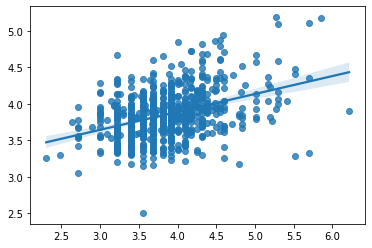

In [42]:
sb.regplot(val_y,preds_val)

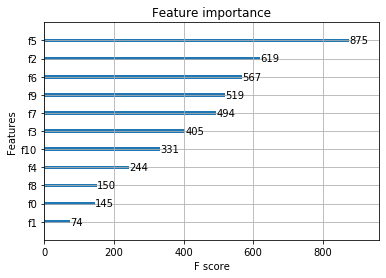

In [44]:
plot_importance(model_base)
plt.show()